# Import

In [1]:
import warnings

# import holoviews as hv
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import numpy as np
import shapely
import pandas as pd
import pystac_client
import xarray as xr
import rioxarray as rio
import pathlib

#import colormaps as cmaps
import pyam # https://pyam-iamc.readthedocs.io/en/latest/index.html
import matplotlib.colors as mcolors

from copy import deepcopy
from typing import List, Dict

# ignore warnings
warnings.filterwarnings("ignore")

# CoCliCo Stac catalog

In [2]:
# load the CoCliCo STAC catalog
catalog = pystac_client.Client.open(
    "https://storage.googleapis.com/coclico-data-public/coclico/coclico-stac/catalog.json"
)
# catalog

# list the datasets present in the catalog, we are interested in the slp5 and slp6 sets
list(catalog.get_children())

[<CollectionClient id=ssl>,
 <CollectionClient id=wef>,
 <CollectionClient id=eesl>,
 <CollectionClient id=floodmaps>,
 <CollectionClient id=sc>,
 <CollectionClient id=cbca>,
 <CollectionClient id=cfr>,
 <CollectionClient id=smd>,
 <CollectionClient id=cisi>,
 <CollectionClient id=slp5>,
 <CollectionClient id=slp6>,
 <CollectionClient id=slp6_pilot>,
 <CollectionClient id=coastal-mask>,
 <CollectionClient id=shorelinemonitor-shorelines>,
 <CollectionClient id=overture-building-footprints>,
 <CollectionClient id=deltares-delta-dtm>,
 <CollectionClient id=shorelinemonitor-raw-series>,
 <CollectionClient id=gcts>,
 <CollectionClient id=gctr>,
 <CollectionClient id=pp>,
 <CollectionClient id=ceed>,
 <CollectionClient id=cfhp>,
 <CollectionClient id=slp>]

# Define parameter

1- Parameters selected by the user

In [14]:
#toggles
yr = 2100  # set year
ccs = "ssp245"  # set climate change scenario 

2- Default parameters

In [15]:
#the var to be shown on the map is always the median (i.e. msl_m) except for the high_end
var = "msl_m" 
if ccs == "high_end":
    var = "msl_h"

# Filter datasets

In [16]:
# define function(s)

# function to put items in dataframe
def items_to_dataframe(items: List[Dict]) -> pd.DataFrame:
    """STAC items to Pandas dataframe.

    Args:
        items (List[Dict]): _description_

    Returns:
        pd.DataFrame: _description_
    """
    _items = []
    for i in items:
        _i = deepcopy(i)
        # _i['geometry'] = shape(_i['geometry'])
        # ...  # for example, drop some attributes that you're not interested in
        _items.append(_i)
    df = pd.DataFrame(pd.json_normalize(_items))
    # for field in ["properties.datetime"]:
    #     if field in df:
    #         df[field] = pd.to_datetime(df[field])
    # df = df.sort_values("properties.datetime")
    return df

# CoCliCo SLR, takes a while +/- 6 min
msl_col = catalog.get_child("slp")
items_msl = list(msl_col.get_items()) # this is slow as we need to list all items
items_msl_df = items_to_dataframe([i.to_dict() for i in items_msl])

In [52]:
# define variables
key_list = ["CCS", "YRS", "QTL"]
fil_idx = []
msl_dict = {key: [] for key in key_list}
for idx, i in enumerate(items_msl_df.id):
    qtl_here = str(i).split("\\")[1]
    yrs_here = int(i.split("\\")[2][0:4])-1
    ccs_here = str(i).split("\\")[0]
    msl_dict["CCS"].append(ccs_here)
    msl_dict["YRS"].append(yrs_here)
    msl_dict["QTL"].append(qtl_here)
    fil_idx.append(idx)

# Select raster to be displayed

In [17]:
for i in items_msl:
    if i.id == r"%s\%s\%s.tif" % (ccs, var, yr+1):
        msl_item_href = i.assets["data"].href

msl_item = rio.open_rasterio(msl_item_href, masked=True)

# cbar limits
vmin = -0.2
vmax = np.nanmax(msl_item)

# colormap
cwd = pathlib.Path().resolve().parent
slev_divl = np.loadtxt(str(pathlib.Path.joinpath(cwd, r"src/coclico/colormaps/slev_div.txt")))
slev_div = mcolors.LinearSegmentedColormap.from_list('slev_div', slev_divl/255)    

# Geospatial Plot

Text(0.5, -0.15, 'longitude (°)')

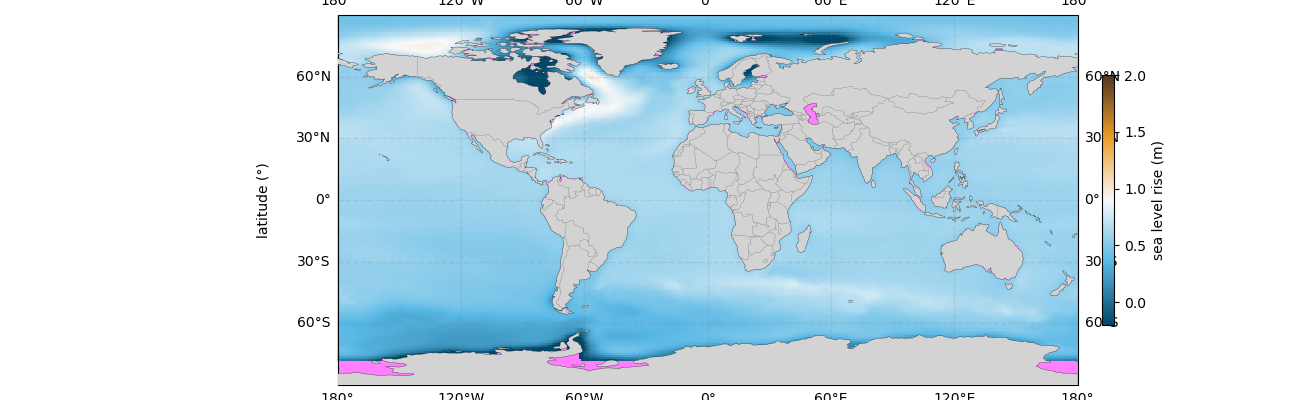

In [19]:
%matplotlib ipympl
# %matplotlib inline

# TODO: make plots with holoviews iso matplotlib
# TODO: zoom with ipyleaflet and converted bbox to this plot?
# TODO: zoom to same extent (sharex, sharey does not work properly) when selecting a boundings box in ipympl

# define figure
fig, (ax1) = plt.subplots(
    1, figsize=(13, 4), subplot_kw={"projection": ccrs.PlateCarree()}
)  # , sharex=True, sharey=True)
fig.tight_layout()
# plt.gcf().subplots_adjust(bottom=0.05)
plt.gcf().subplots_adjust(left=0.05)

# populate MSL plot
ax1.set_facecolor((1.0, 0.0, 1.0, 0.5)) 
im = msl_item.plot(
    ax=ax1,
    add_colorbar=False,
    vmin=-0.2, #round(vmin, 2),
    vmax=2, #round(vmax, 2),
    cmap=slev_div,
)
ax1.set_title("%s \nRCP%s, %s, median" % (msl_col.title, ccs, yr))
# ax1.set_xlabel("Longitude [Degrees East]") # TODO: possibly import from file?
# ax1.set_ylabel("Latitude [Degrees North]") # TODO: possibly import from file?
cbar = plt.colorbar(im, shrink=0.675, aspect=30 * 0.675, pad=0.02)
cbar.set_label(
   "sea level rise (%s)" % msl_col.extra_fields["deltares:units"]
)  # TODO: possibly import from file?
ax1.add_feature(cf.LAND, facecolor="lightgrey", zorder=15)
ax1.add_feature(cf.COASTLINE, linewidth=0.2, zorder=16)
ax1.add_feature(cf.BORDERS, linewidth=0.1, zorder=16)
gl1 = ax1.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    linewidth=1,
    color="gray",
    alpha=0.2,
    linestyle="--",
)
gl1.xlabels_top = False
gl1.ylabels_right = False
ax1.text(
    -0.09,
    0.5,
    "latitude (°)",
    va="bottom",
    ha="center",
    rotation="vertical",
    rotation_mode="anchor",
    transform=ax1.transAxes,
)
ax1.text(
    0.5,
    -0.15,
    "longitude (°)",
    va="bottom",
    ha="center",
    rotation="horizontal",
    rotation_mode="anchor",
    transform=ax1.transAxes,
)


# Temporal plot

In [21]:
# select a point to plot timeseries of SLR projections for
point_location = [4.2, 52.8]  # easting, norting
point_geom = shapely.Point(point_location)

In [75]:
# retrieve MSL projections at above-defined location

# pre-processing function
def preprocess(ds):
    point_geom = shapely.Point(point_location)
    
    ds = (
        ds.rio.clip([point_geom])
        .sel(x=point_location[0], y=point_location[1], method="nearest")
    )

    return ds

# concat datasets
selected_ds = xr.open_mfdataset(
    [i.assets["data"].href for i in items_msl],
    engine="rasterio",
    concat_dim="band",
    combine="nested",
    preprocess=preprocess,  # this indexes every before merging them
    parallel=True, # this is for Dask
)

msl_dict["SLR"] = selected_ds["band_data"].values
df = pd.DataFrame(data=msl_dict)

Text(125.09722222222221, 0.5, 'mean sea-level change (m)')

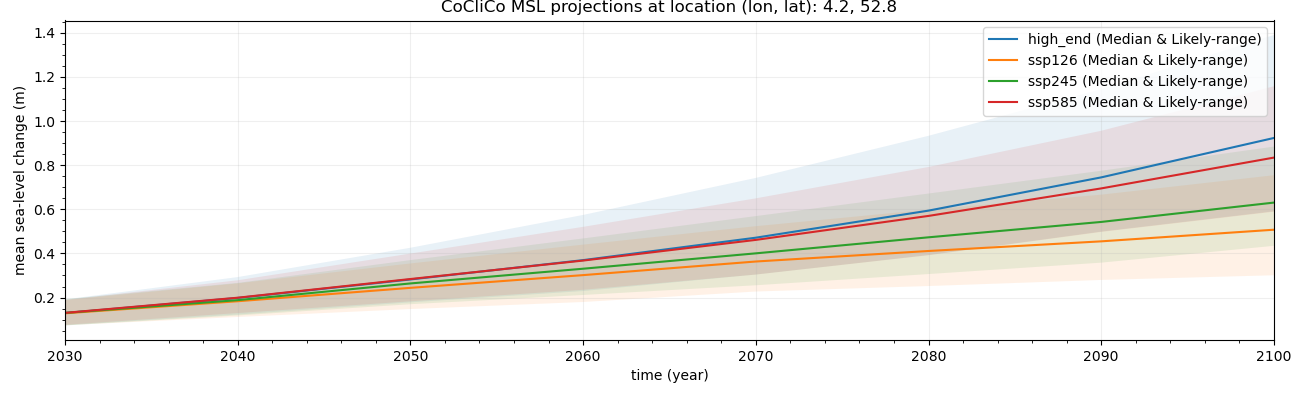

In [88]:
%matplotlib ipympl
# %matplotlib inline

# define figure
fig, (ax1) = plt.subplots(1, figsize=(13, 4), sharey=True, sharex=True)
fig.tight_layout()
plt.gcf().subplots_adjust(bottom=0.15)
plt.gcf().subplots_adjust(left=0.05)
ax = plt.gca()
colors = pyam.plotting.PYAM_COLORS # official color package

for idx, (scen, grp) in enumerate(df[df.YRS <= 2100].groupby(["CCS"])):
    ens_list = list(grp.groupby("QTL"))
    ens_list[2][1].plot(
        kind="line",
        x="YRS",
        y="SLR",
        label="%s (Median & Likely-range)" % (scen),
        #color=colors["AR5-RCP-"+str(scen[0][0:-1]) + "." +str(scen[0][-1])],#np.array(colorsAR5[idx])/255,
        ax=ax1,
        alpha=1.0,
    )  # mean 50 percentile
    ax1.fill_between(
        ens_list[0][1].YRS,
        ens_list[1][1].SLR,
        ens_list[0][1].SLR,
        alpha=0.1,
        #color=colors["AR5-RCP-"+str(scen[0][0:-1]) + "." +str(scen[0][-1])],#np.array(colorsAR5[idx])/255,
        interpolate=True,
    )  # 5-95th percentile shading

ax1.set_title(
    "CoCliCo MSL projections at location (lon, lat): %s, %s" % (point_location[0], point_location[1])
)
ax1.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax1.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax1.set_xlim(2030, 2100)
ax1.grid(alpha=0.2)
ax1.set_xlabel("time (year)")
ax1.set_ylabel("mean sea-level change (m)")

In [85]:
scen

('ssp585',)